In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [54]:
G = 6.674e-11 #N m^2 kg^-2

#Boltzmann's constant
k_b = 1.3807e-23 # J K^-1

#speed of light
c = 3e8 #m/s

#Hydrogen Mass:
m_H = 1.67353e-27 #kg

meters_per_au = 1.49e11
meters_per_pc = 3.086e16
seconds_per_year = 3600*24*365



In [42]:
M_sun = 2e30 #kg
rho = 3e-17 #kg m^-3 (Carrol/Ostlie P 414)
M = M_sun *10 #(Carrol/Ostlie P 414)
# rho = m/V => V=m/rho

V = M/rho
r3 = 3*V/(4*np.pi)
r = np.power(r3, 1./3.)

print(f'r: {r:.2e} meters, or {r/meters_per_au:.2e} au or {r/meters_per_pc:.2e} pc')

r: 5.42e+15 meters, or 3.64e+04 au or 1.76e-01 pc


## free fall time ala Carrol/Ostlie

\begin{equation}
t_{ff} = \left(\frac{3\pi}{32} \frac{1}{G\rho_0} \right)^\frac{1}{2}
\end{equation}

where $\rho_0$ is the intial mass density of the cloud

In [11]:
#free fall time ala Carrol/Ostlie
def t_free_fall(rho):
    t_ff = np.sqrt(3*np.pi/(32*G*rho))
    return t_ff

In [14]:
t_ff = t_free_fall(rho)
print(f'Free fall time: {t_ff:.2e} s or {t_ff/seconds_per_year:.2e} year')

Free fall time: 1.21e+13 s or 3.85e+05 year


In [61]:
def t_ff_euler(M, r0, t, v0=0.0):
    r_t = np.zeros(len(t))
    v_t = np.zeros(len(t))

    #initial conditions at t=0
    r_t[0] = r0
    v_t[0] = v0

    for i in range(1, len(t)):
        dt = t[i]-t[i-1]

        #gravitational acceleration
        a = -G*M/(r_t[i-1]**2) 
        v_t[i] = v_t[i-1] + a*dt
        r_t[i] = r_t[i-1] + v_t[i-1]*dt

        if r_t[i] <= 0:
            break

    return r_t[:i+1], v_t[:i+1], t[:i+1]




In [66]:
t, dt = np.linspace(0, t_ff*1.25, 1000000, retstep=True)
print(f'dt: {dt:.2e} seconds or {dt/seconds_per_year:.2f} years')

r_t, v_t, t = t_ff_euler(M, r, t)


t_ff_e = t[-1]

print(f'Euler approx: Free fall time: {t_ff_e:.2e} seconds or {t_ff_e/seconds_per_year:,.0f} years')
print(f'Approximation Error: {100.0*(t_ff_e/t_ff-1):.2f} %')
print()
print(f'Initial radius: {r:.2e} m, Final radius: {r_t[-1]:.2e} m')
print(f'Final velocity: {-v_t[-1]:.2e} m/s')

dt: 1.52e+07 seconds or 0.48 years
Euler approx: Free fall time: 1.21e+13 seconds or 384,594 years
Approximation Error: 0.00 %

Initial radius: 5.42e+15 m, Final radius: -1.89e+11 m
Final velocity: 1.04e+05 m/s


Text(0.5, 0, 'Years')

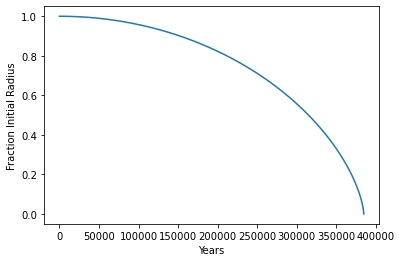

In [67]:
plt.plot(t/seconds_per_year,r_t/r)
plt.ylabel('Fraction Initial Radius')
plt.xlabel('Years')

Text(0.5, 0, 'years')

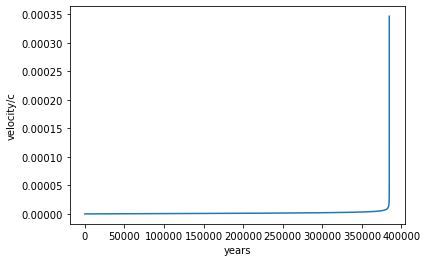

In [68]:
plt.plot(t/seconds_per_year, -v_t/c)
plt.ylabel('velocity/c')
plt.xlabel('years')

Carroll/Ostlie Page 286, eq 10.5:

\begin{equation}
    dm\ddot{r} = -F{grav} + F_P
\end{equation}
Deriving and substituting expressions for $F_{grav}$ and $F_P$ (full details of which to be provided in thre final paper) into the equation above produces the following equation of motion from 
\begin{align}
    \ddot{r} &= \frac{1}{\rho}\left( -G\frac{M_r\rho}{r^2} - \frac{dP}{dr}\right)
\end{align}

Since the gas is ideal
\begin{align}
    PV &= NkT \\
    P &= \frac{NkT}{\frac{4}{3}\pi r^3} \\
    \frac{dP}{dr} &= -\frac{9}{4\pi} \frac{NkT}{r^4}
\end{align}

In [177]:
def HSE_euler(M, r0, T0, t, v0=0.0, atomic = True):
    
    # time series for state variables
    r_t = np.zeros(len(t)) # radius
    v_t = np.zeros(len(t)) # velocity
    a_t = np.zeros(len(t)) # acceleration
    P_t = np.zeros(len(t)) # pressure
    V_t = np.zeros(len(t)) # Volume
    T_t = np.zeros(len(t)) # temperature (K)
    rho_t = np.zeros(len(t)) # mass density

    #number of particles:
    n_p = 1 if atomic else 2 #molecular or atomic hydrogen
    # number of particles is mass  div'd by mass of each particle
    N = M/(n_p*m_H)

    #initial conditions at t=0
    r_t[0] = r0
    v_t[0] = v0
    a_t[0] = 0 
    T_t[0] = T0; dT_dt = 0 # for now
    V_t[0] = (4.0/3.0)*np.pi*np.power(r0,3)
    P_t[0] = N*k_b*T0/V_t[0]
    rho_t[0] = M/V_t[0]

    for i in range(1, len(t)):
        dt = t[i]-t[i-1]

        #pressure change:
        dp_dr = -(9/4*np.pi)*(N*k_b*T_t[i-1]/np.power(r_t[i-1],4))

        #acceleration
        a = (1/rho_t[i-1])*((-G*M*rho_t[i-1]/r_t[i-1]**2) - dp_dr)
        a_t[i] = a
        v_t[i] = v_t[i-1] + a*dt
        r_t[i] = r_t[i-1] + v_t[i-1]*dt

        T_t[i] = T_t[i-1] + dT_dt*dt
        V_t[i] = (4.0/3.0)*np.pi*np.power(r_t[i],3)
        P_t[i] = N*k_b*T_t[i]/V_t[i]
        rho_t[i] = M/V_t[i]

        if r_t[i] <= 0:
            break
    print(f'Stopping after {i} iterations') 
    
    res = {'Radius':r_t[:i], 'Velocity': v_t[:i], 'Acceleration': a_t[:i],
            'Pressure':P_t[:i], 'Temperature':T_t[:i], 
            'Density':rho_t[:i], 'Time':t[:i]}
    
    return res

In [206]:
def plot_res(res):
    years = res['Time']/seconds_per_year
    fig, axs = plt.subplots(figsize=(12,8), nrows=2, ncols=2)
    axs = axs.flatten()
    axs[0].plot(years, res['Radius'])
    axs[0].set_ylabel('Meters')
    axs[0].set_xlabel('Years')
    axs[0].set_title('Radius')

    axs[1].semilogy(years, res['Pressure'])
    axs[1].set_ylabel('Pressure')
    axs[1].set_xlabel('Years')
    axs[1].set_title('Pressure')

    axs[2].semilogy(years, res['Density'])
    axs[2].set_ylabel('kg/m^3')
    axs[2].set_xlabel('Years')
    axs[2].set_title('Density')

    axs[3].plot(years, res['Temperature'])
    axs[3].set_ylabel('K')
    axs[3].set_xlabel('Years')
    axs[3].set_title('Temperature')

    fig.tight_layout()

In [157]:
#Ostlie P 413, eq 12.14
def jeans_mass(T, n, atomic = True):
    # n is particle density: particles per cubic meter
    mu = 1 if atomic else 2
    rho_0 = mu*m_H*n

    m_j = np.power(5*k_b*T/(G*mu*m_H), 3./2)*np.power(3/(4*np.pi*rho_0),1./2)
    return m_j

def jeans_length(T, n, atomic = True):
    # n is particle density: particles per cubic meter
    mu = 1 if atomic else 2
    rho_0 = mu*m_H*n

    R_j = np.power(15*k_b*T/(4*np.pi*G*mu*m_H*rho_0), 1/2)

    return R_j

#Maoz P 116, eq 5.6
def jeans_mass_maoz(r, T,  atomic=True):
    mbar = m_H if atomic else 2*m_H
    m_j = 3*k_b*T/(G*mbar)

    return m_j

def jeans_length_maoz(M, T, atomic=True):
    mbar = m_H if atomic else 2*m_H
    r_j = G*mbar*M/(3*k_b*T)

    #mass density
    rho_j = (3/(4*np.pi*M**2))*np.power((3*k_b*T)/(G*mbar),3)

    #particle density
    n_bar = rho_j/mbar


    return r_j, rho_j, n_bar


In [114]:
#See example 12.2.1 P 414
jeans_mass(50, 5e8)/M_sun

1450.9531521249287

In [116]:
#See example 12.2.1 P 414
jeans_mass(10, 1e10, atomic=False)/M_sun

7.254765760624645

In [143]:
print(f'Jeans length: {jeans_length(10, 1e10, atomic=False)/meters_per_au:.2e} au')

Jeans length: 3.15e+04 au


In [158]:
r_j, rho_j, n_bar = jeans_length_maoz(1000*M_sun, 20.0, atomic=False)

print(f'Jeans length: {r_j/meters_per_au:.2e} au, Jeans density: {rho_j:.2e} kg/m^3, particle density: {n_bar:.2e}')

Jeans length: 3.62e+06 au, Jeans density: 3.04e-21 kg/m^3, particle density: 9.09e+05


In [121]:
M_sun = 2e30 #kg
rho = 3e-17 #kg m^-3 (Carrol/Ostlie P 414)
M = M_sun *10 #(Carrol/Ostlie P 414)
# rho = m/V => V=m/rho

V = M/rho
r3 = 3*V/(4*np.pi)
r = np.power(r3, 1./3.)

print(f'r: {r:.2e} meters, or {r/meters_per_au:.2e} au or {r/meters_per_pc:.2e} pc')

r: 5.42e+15 meters, or 3.64e+04 au or 1.76e-01 pc


In [159]:
t, dt = np.linspace(0, t_ff*1.25, 10000, retstep=True)
print(f'dt: {dt:.2e} seconds or {dt/seconds_per_year:.2f} years')

dt: 1.52e+09 seconds or 48.08 years


In [160]:
res = HSE_euler(M/1000, r, 100.0, t)

Stopping after 1284 iterations


Stopping after 9999 iterations


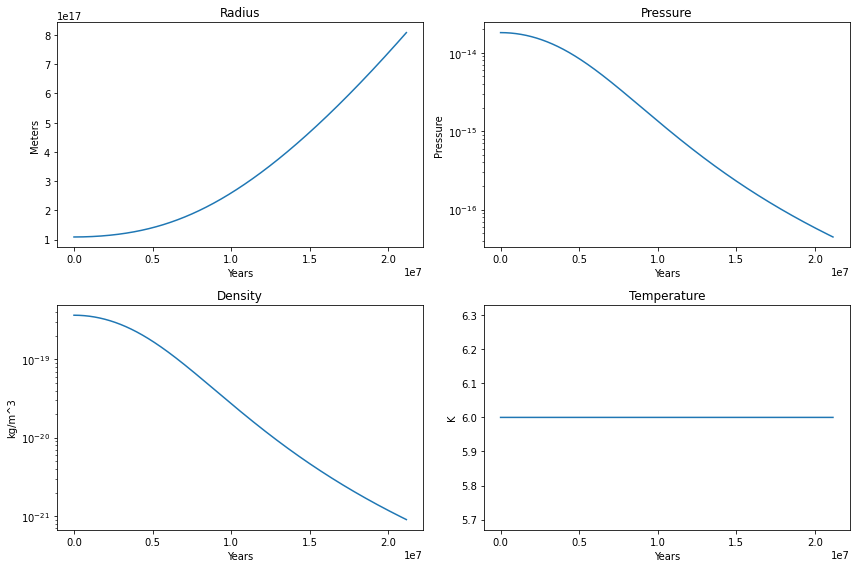

In [224]:
t, dt = np.linspace(0, t_ff*55, 10000, retstep=True)
res = HSE_euler(1000*M_sun, r_j*0.2026, 5, t, atomic=True)
plot_res(res)
